In [12]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [13]:
# Choose a target
target = "NR-AR"

# import the processed dataset for algorithms what require scaled variables
print('Load Pickle')
pickle_in = open(target + "_processeddata.pkl", "rb")
[param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test] = pickle.load(pickle_in)
pickle_in.close()
print('Finished')

# standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Load Pickle
Finished


As a first model (**baseline model**), we use kNN.

In [14]:
# Train the model
clf = KNeighborsClassifier(n_neighbors=8)
clf.fit(X_train, y_train)

# Predict the test set
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

Calculate performance metrics for the model

In [15]:
# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   0.97   |     0.49    |    1.00     |   0.83
test   |   0.97   |     0.40    |    1.00     |   0.81

train F1-Score: 0.62
test F1-Score: 0.54


Notice our kNN model with 8 nearest-neighbours is able to achieve very high **accuracies** of up to 98\%. Equivalently, the specifity is 1.

The **sensitivity** of the model remains relatively low, however, with values of around 0.4 and 0.5. 

This is characteristic for class imbalance in the dataset: in a highly imbalanced dataset, predicting the majority class (non-toxic) for most samples results in a high accuracy but does not reflect the model’s ability to correctly classify the minority class (toxic).

Low sensitivity is very problematic for models predicting toxicity, as it indicates a high probability of a toxic compound being labeled non-toxic (False Negative). This does not show up in the accuracy metric as most compounds get classified correctly (the large majority of  compounds are non-toxic and get classified as such).

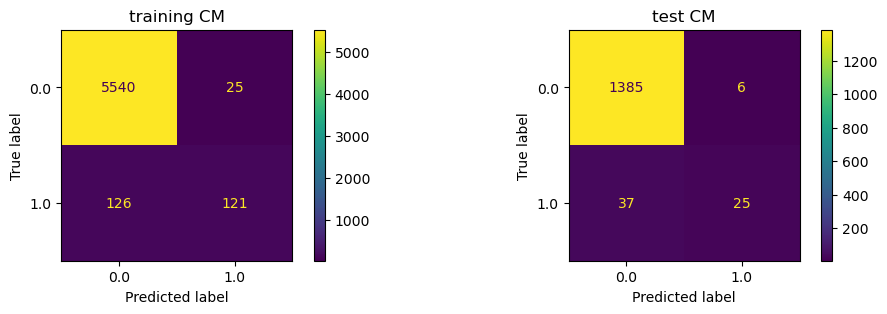

In [16]:
# plot the confusion matrices for training and test sets
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
# confusion matrix of the training set as the second subplot
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_train,y_pred_train, ax=ax3)
# set the title for the subplot
ax3.title.set_text('training CM')
# confusion matrix of the test set as the third subplot
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, ax=ax4)
ax4.title.set_text('test CM')

train ROC-AUC: 0.97
test ROC-AUC: 0.72
train PR-AUC: 0.73
test PR-AUC: 0.48


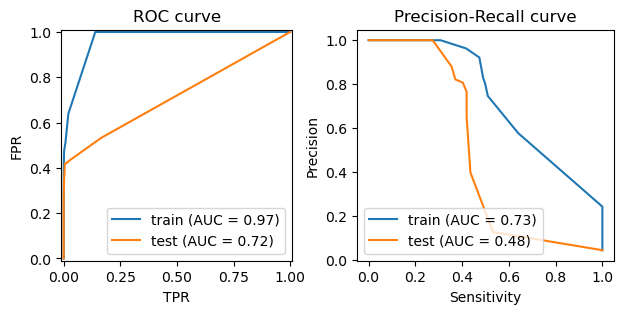

In [25]:
# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.3, 3))

# ROC-AUC plots as the first subplot
y_train_prob = clf.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = clf.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')
ax1.title.set_text('ROC curve')

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

Instead of using the ROC-AUC, in case of highly imbalanced data, the Precision-Recall (PR) curve (and the area under the curve PR-AUC) is used instead, as it focusses on the performance of the minority class, i.e. toxic compounds.

We now test the influence of the amount of nearest-neighbours on these metrics.

In [10]:
# initiate lists to store the evaluation metrics
training_accuracy = []
test_accuracy = []
training_sensitivity = []
test_sensitivity = []
training_specifity = []
test_specifity = []
training_precision = []
test_precision = []
training_f1 = []
test_f1 = []
training_prauc = []
test_prauc = []

# try n_neighbors from 1 to 15
neighbors_settings = range(1, 15)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # predict the test set
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test) 
    # calculate the evaluation metrics
    training_accuracy.append(metrics.accuracy_score(y_train, y_pred_train))
    test_accuracy.append(metrics.accuracy_score(y_test, y_pred_test))
    training_sensitivity.append(metrics.recall_score(y_train, y_pred_train, pos_label=1))
    test_sensitivity.append(metrics.recall_score(y_test, y_pred_test, pos_label=1))
    training_specifity.append(metrics.recall_score(y_train, y_pred_train, pos_label=0))
    test_specifity.append(metrics.recall_score(y_test, y_pred_test, pos_label=0))
    training_precision.append(metrics.precision_score(y_train, y_pred_train, pos_label=1))
    test_precision.append(metrics.precision_score(y_test, y_pred_test, pos_label=1))
    precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
    precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')
    training_f1.append(f1_score_train)
    test_f1.append(f1_score_test)
    y_train_prob = clf.predict_proba(X_train)[:,1]
    y_test_prob = clf.predict_proba(X_test)[:,1]
    precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
    precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
    training_prauc.append(metrics.auc(recall_curve_train, precision_curve_train))
    test_prauc.append(metrics.auc(recall_curve_test, precision_curve_test))

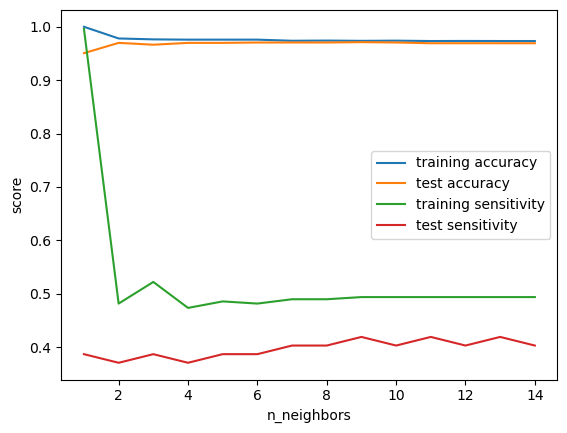

In [11]:
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.plot(neighbors_settings, training_sensitivity, label="training sensitivity")
plt.plot(neighbors_settings, test_sensitivity, label="test sensitivity")
plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

Notice both the accuracy and the sensitivity are relatively stable wrt the amount of NN, with the accuracy staying very high (close to 1) and the sensitivity around 0.5. 

plt.plot(neighbors_settings, training_f1, label="training f1")
plt.plot(neighbors_settings, test_f1, label="test f1")
plt.plot(neighbors_settings, training_prauc, label="training pr-auc")
plt.plot(neighbors_settings, test_prauc, label="test pr-auc")
plt.ylabel("accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

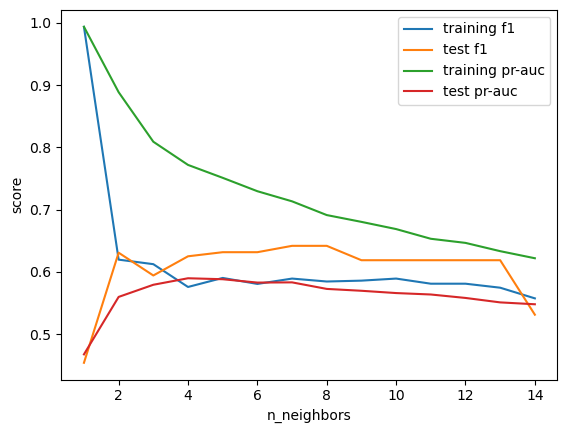

In [9]:
plt.plot(neighbors_settings, training_f1, label="training f1")
plt.plot(neighbors_settings, test_f1, label="test f1")
plt.plot(neighbors_settings, training_prauc, label="training pr-auc")
plt.plot(neighbors_settings, test_prauc, label="test pr-auc")
plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

Notice the training f1-score and PR-AUC go down with the number of neighbours, indicating for low amount of NN the minority class is overfitted.

**In conclusion, our baseline model is able to achieve very high accuracies, but for imbalanced data sets, this is not a good metric to asses performance. A better model should achieve higher sensitivities, f1-score and PR-AUC.**